A slightly more in-depth look at synapses.

Starting with basic connection, neuron with sinusoidal input current is connected to a latent(?) neuron.

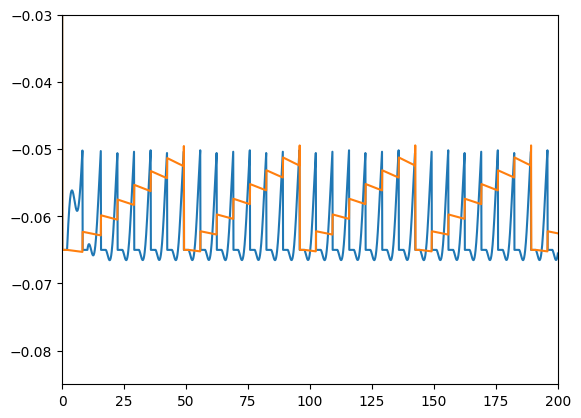

In [29]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

from neurodynex3.tools import input_factory, plot_tools

start_scope()

v_rest = -70 * mV
v_reset = -65 * mV
threshold = -50 * mV
membrane_r = 10. * Mohm
refractory = 2.0 * ms
run_time = 200*ms

curr = input_factory.get_sinusoidal_current(
        0, 2000, unit_time=0.1 * ms,
        amplitude=2.5 * namp, frequency=150 * Hz, direct_current=2. * namp)

start_scope()

eqs = '''
dv/dt = ( -(v - v_rest) + membrane_r * curr(t, 0) * I ) / tau : volt (unless refractory)
I : 1
tau : second
'''
G = NeuronGroup(
2, eqs, threshold='v > threshold', 
reset="v = v_reset", method="linear", refractory=refractory)
G.I = [2, 0]
G.tau = [10, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre="v_post += w * mV")
S.connect(i=0, j=1)
S.w = '3'

M = StateMonitor(G, 'v', record=True)

run(run_time)

plt.plot(M.t/ms, M.v[0], label='Neuron 0')
plt.plot(M.t/ms, M.v[1], label='Neuron 0')
plt.xlim(0, run_time/ms)
plt.ylim(-0.085, -0.03);

Here we demonstrate cyclical connectivity. We connect a neuron from excitatory group E to a neuron from inhibitory group I, and vice versa. This makes the network stabilise at a lower firing rate of ~4.8 ms

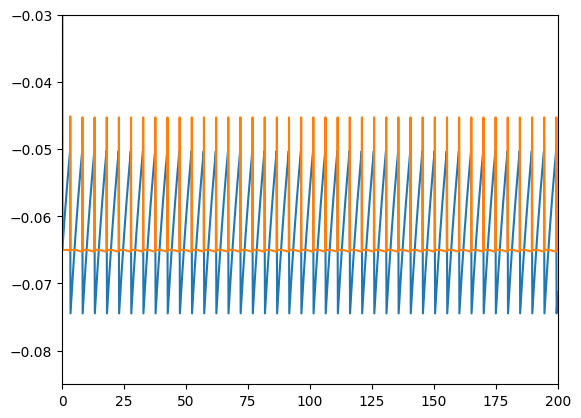

In [31]:
start_scope()

tmp = np.zeros((300, 1)) * amp
tmp[0:] = 3*namp
curr = TimedArray(tmp, dt=1. * ms)

eqs = '''
dv/dt = ( -(v - v_rest) + membrane_r * curr(t, 0) * I ) / tau : volt (unless refractory)
I : 1
tau : second
'''
E = NeuronGroup(
1, eqs, threshold='v > threshold', 
reset="v = v_reset", method="linear", refractory=0 * ms)
E.I = [2]
E.tau = [10]*ms

I = NeuronGroup(
1, eqs, threshold='v > threshold', 
reset="v = v_reset", method="linear", refractory=refractory)
I.I = [0]
I.tau = [50]*ms

S_e = Synapses(E, I, 'w : 1', on_pre="v_post += w * mV")
S_e.connect(i=0, j=0)
S_e.w = '20'
S_i = Synapses(I, E, 'w : 1', on_pre="v_post += w * mV")
S_i.connect(i=0, j=0)
S_i.w = '-10'

M = StateMonitor(E, 'v', record=True)
M_i = StateMonitor(I, 'v', record=True)
Sp = SpikeMonitor(E, 't')
Sp_i = SpikeMonitor(I, 't')

run(run_time)

plt.plot(M.t/ms, M.v[0], label='Neuron 0')
plt.plot(M_i.t/ms, M_i.v[0], label='Neuron 0')
plt.xlim(0, run_time/ms)
plt.ylim(-0.085, -0.03);

In [5]:
times = [t/ms for t in Sp.t]
intervals = [t - s for s, t in zip(times, times[1:])]
np.mean(intervals)

4.858536585365854

Demonstration of time-varying weights. The postsynaptic neuron eventually stops spiking because the excitation rate is overcome by the natural LIF decay rate.

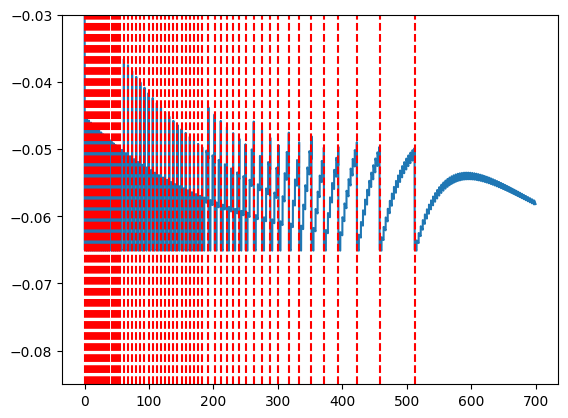

In [34]:
from LIF import lif_neuron

tmp = np.zeros((300, 1)) * amp
tmp[0:] = 3*namp
curr = TimedArray(tmp, dt=1. * ms)

start_scope()

eqs = '''
dv/dt = ( -(v - v_rest) + membrane_r * curr(t, 0) * I ) / tau : volt (unless refractory)
I : 1
tau : second
'''
E = NeuronGroup(
1, eqs, threshold='v > threshold', 
reset="v = v_reset", method="linear", refractory=0 * ms)
E.I = [2]
E.tau = [10]*ms

I = NeuronGroup(
1, eqs, threshold='v > threshold', 
reset="v = v_reset", method="linear", refractory=refractory)
I.I = [0]
I.tau = [50]*ms

S = Synapses(E, I, model='dw/dt = -w / (200 * ms) : 1', on_pre='v_post += w * mV', method="exact")
S.connect(i=0, j=0)
S.w = 20.0

M = StateMonitor(E, 'v', record=True)
M_i = StateMonitor(I, 'v', record=True)
Sp = SpikeMonitor(E, 't')
Sp_i = SpikeMonitor(I, 't')

run(700 * ms)

# plt.plot(M.t/ms, M.v[0])
plt.plot(M_i.t/ms, M_i.v[0])
# plt.xlim(0, 250)
plt.ylim(-0.085, -0.03);
for s in Sp_i.t:
    
    plt.axvline(s/ms, color="red", ls="--")